### Single Cell Analysis (10k Mouse Spleen)

A whole spleen was harvested from an adult mouse (male C57BL/6, 66 days old) and fixed with 10% neutral-buffered formalin, and processed in-house into a formalin-fixed paraffin-embedded (FFPE) blocks. Cells were isolated from three, 50 micron FFPE curls (sagittal section) following the demonstrated protocol Isolation of Cells from FFPE Tissue Sections for Chromium Fixed RNA Profiling (CG000632), using the gentleMACS Octo Dissociator option.

The Fixed RNA Gene Expression library was generated as described in the Chromium Fixed RNA Profiling for Singleplexed Samples with Feature Barcode technology for Cell Surface Protein User Guide (CG000477). The resulting library was sequenced on an Illumina NovaSeq6000 with approximately 15k read pairs per cell.

Total 8,268 cells detected
Paired-end, dual indexing: 28 cycles Read 1, 10 cycles i7, 10 cycles i5, 90 cycles Read 2

Soure: https://www.10xgenomics.com/datasets/10k-mouse-spleen-ffpe-tissue-dissociated-using-gentlemacs-dissociator-singleplex-sample-1-standard

In [4]:
import scanpy as sc
import numpy as np
import pandas as pd

In [5]:
adata = sc.read_10x_h5("/root/10k_mouse_spleen_scFFPE_singleplex_Multiplex_count_raw_feature_bc_matrix.h5")

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [6]:
adata.var_names_make_unique()

In [8]:

# Print the shape of the data matrix
print("Data shape:", adata.shape)

# Print the names of the variables (genes)
print("Variable names:", adata.var_names)

# Print the names of the observations (cells)
print("Observation names:", adata.obs_names)

# Print the names of the annotations (columns in obs)
print("Annotation names:", adata.obs.columns)

# Print the names of the layers
print("Layer names:", adata.layers.keys())

# Print the names of the uns (unstructured) annotations
print("Uns annotation names:", adata.uns.keys())

Data shape: (517380, 32344)
Variable names: Index(['Xkr4', 'Gm1992', 'Gm19938', 'Gm37381', 'Rp1', 'Sox17', 'Gm37587',
       'Gm37323', 'Mrpl15', 'Lypla1',
       ...
       'DEPRECATED_ENSMUSG00000055963', 'DEPRECATED_ENSMUSG00000055971',
       'DEPRECATED_ENSMUSG00000056493', 'DEPRECATED_ENSMUSG00000058685',
       'DEPRECATED_ENSMUSG00000059022', 'DEPRECATED_ENSMUSG00000060701',
       'DEPRECATED_ENSMUSG00000067081', 'DEPRECATED_ENSMUSG00000068327',
       'DEPRECATED_ENSMUSG00000068479', 'DEPRECATED_ENSMUSG00000102206'],
      dtype='object', length=32344)
Observation names: Index(['AAACAAGCAAACAAGA-1', 'AAACAAGCAAACAATC-1', 'AAACAAGCAAACACGC-1',
       'AAACAAGCAAACCCAA-1', 'AAACAAGCAAACCGGT-1', 'AAACAAGCAAACCGTA-1',
       'AAACAAGCAAACCTGA-1', 'AAACAAGCAAACGGGA-1', 'AAACAAGCAAACTTGG-1',
       'AAACAAGCAAAGAACA-1',
       ...
       'TTTGTGAGTTTGCAAC-1', 'TTTGTGAGTTTGCATA-1', 'TTTGTGAGTTTGCTCC-1',
       'TTTGTGAGTTTGGCCA-1', 'TTTGTGAGTTTGTAGC-1', 'TTTGTGAGTTTGTCAA-1',
       

In [11]:
# Identify mitochondrial genes
mito_genes = adata.var_names.str.startswith('mt-')


# Filter out cells with high mitochondrial gene content
adata = adata[adata.obs['percent_mito'] < 0.05, :]

In [13]:
# Quality control
sc.pp.filter_cells(adata, min_genes=200)  # Filter cells with less than 200 expressed genes
sc.pp.filter_genes(adata, min_cells=3)   # Filter genes expressed in less than 3 cells


In [14]:
adata

AnnData object with n_obs × n_vars = 11572 × 14780
    obs: 'percent_mito', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

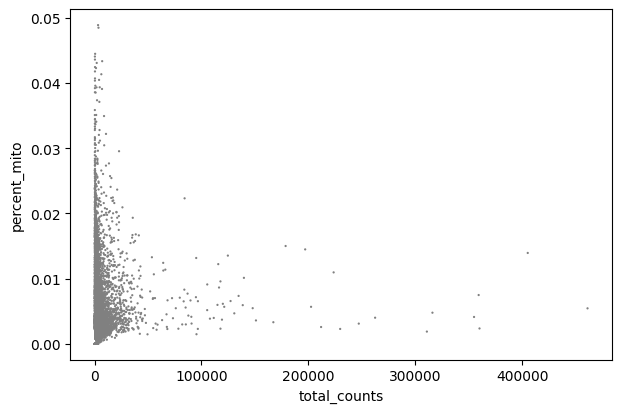

In [15]:
# scatter plot of the mitochondrial gene content against the total counts
adata.obs['total_counts'] = adata.X.sum(axis=1)
sc.pl.scatter(adata, x='total_counts', y='percent_mito')


In [16]:
# Normalization
sc.pp.normalize_total(adata, target_sum=1e4)  # Normalize total counts to 10,000

# Logarithmic transformation
sc.pp.log1p(adata)  # Logarithmize the data


In [17]:
# Scaling
sc.pp.scale(adata, max_value=10)  # Scale the data to have maximum value of 10


In [18]:
# Identifying highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

# Subset of data to only include highly variable genes
adata = adata[:, adata.var['highly_variable']]

In [20]:

# Principal component analysis (PCA)
sc.tl.pca(adata, svd_solver='auto') 

In [21]:

# Compute a neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_pca')

In [22]:

# Clustering
sc.tl.leiden(adata)  


<ipython-input-22-d9af8359c0f4>:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


In [23]:


# Embedding visualization
sc.tl.umap(adata)  # Compute UMAP embedding

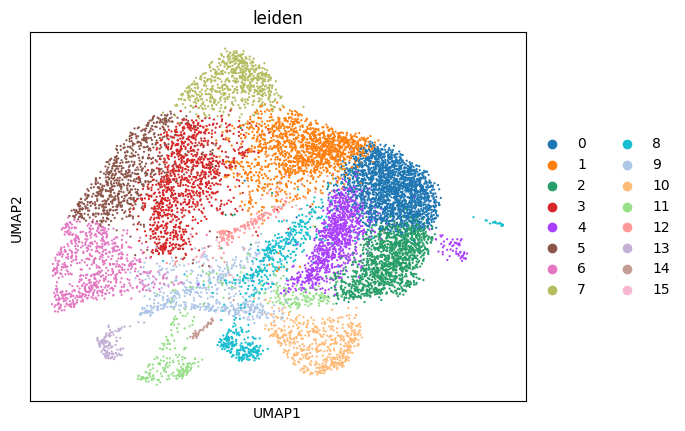

In [24]:

# plotting 
sc.pl.umap(adata, color=['leiden'])

In [26]:
# compute clusters using the leiden method and store the results with the name `clusters`
sc.tl.leiden(
    adata,
    key_added="clusters",
    resolution=0.5,
    n_iterations=2,
    flavor="igraph",
    directed=False,
)

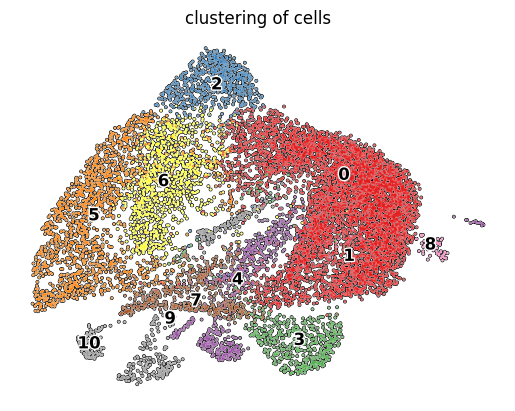

In [28]:
sc.pl.umap(
        adata,
        color="clusters",
        add_outline=True,
        legend_loc="on data",
        legend_fontsize=12,
        legend_fontoutline=2,
        frameon=False,
        title="clustering of cells",
        palette="Set1",
    )

In [36]:
sc.tl.leiden(adata)

In [37]:
# differential expression analysis
sc.tl.rank_genes_groups(adata, groupby='leiden')


/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: 

In [38]:

# Get top genes for each cluster
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges', 'pvals']})

,0_n,0_l,0_p,1_n,1_l,1_p,2_n,2_l,2_p,3_n,...,12_p,13_n,13_l,13_p,14_n,14_l,14_p,15_n,15_l,15_p
0,Igkc,NaN,4.011131e-178,Cst3,NaN,4.309541e-10,Igkc,NaN,0.000000e+00,Smc4,...,1.946595e-37,Igkc,NaN,2.023743e-62,Irf8,NaN,1.809175e-31,Cd9,NaN,6.648416e-14
1,Iglc3,NaN,1.553118e-47,Slpi,NaN,5.527189e-02,Iglc3,NaN,3.457960e-160,E2f8,...,2.732140e-23,Txndc5,NaN,1.258592e-49,Cd300c,NaN,1.583281e-14,Slc2a3,NaN,1.209289e-11
2,Iglc1,NaN,5.290455e-18,Slc40a1,NaN,5.686410e-02,Ctss,NaN,3.585480e-155,Apeh,...,1.720682e-22,Creld2,NaN,4.087423e-40,Grm8,NaN,5.965903e-13,Pls1,NaN,5.595290e-07
3,Khnyn,NaN,1.147662e-11,Fyb2,NaN,7.043890e-02,Mzb1,NaN,3.496944e-131,Tacc3,...,3.975100e-22,Mzb1,NaN,1.838018e-39,Havcr1,NaN,8.498328e-11,Gsn,NaN,7.205612e-07
4,Itpr2,NaN,2.073898e-09,Speer4c,NaN,1.195727e-01,Irf8,NaN,9.723521e-110,Otud5,...,3.369124e-16,Iglc1,NaN,3.916139e-24,Snx18,NaN,2.506122e-09,Lmna,NaN,1.041576e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,Lig1,NaN,2.479999e-229,Kdm5a,NaN,8.762826e-116,Rad54l,NaN,1.972242e-119,Traf1,...,3.975618e-23,Trat1,2.661494,3.978641e-23,Adgrb2,2.635967,9.452610e-24,Dhx40,NaN,6.711133e-19
1996,E2f8,NaN,2.069653e-233,Slc38a9,NaN,2.667507e-127,Myh10,NaN,5.106761e-136,Tcp11l2,...,1.173476e-19,BC049715,2.585307,1.967915e-23,Oat,NaN,3.831909e-14,Irf8,NaN,8.853572e-19
1997,Trak2,NaN,9.559674e-237,Otud5,NaN,7.372263e-124,Espl1,NaN,9.972179e-139,Irf8,...,2.338351e-25,Akr1c13,2.485983,4.309318e-24,Emp1,2.722532,2.761796e-26,Arrdc2,NaN,1.101924e-22
1998,Myh10,NaN,1.224983e-255,Rbm33,NaN,6.783194e-125,Cip2a,NaN,2.407360e-149,Cmtm7,...,8.736980e-21,Camsap3,2.539055,1.233144e-24,Espl1,NaN,1.912274e-19,Nxpe3,NaN,2.338229e-235


In [42]:
clusters = adata.uns['rank_genes_groups']['names'].dtype.names
print(clusters)

('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15')


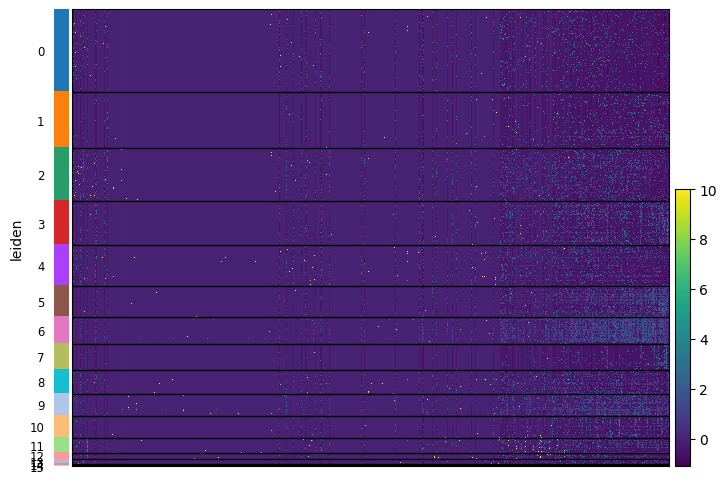

In [44]:
sc.pl.heatmap(adata, var_names=adata.uns['rank_genes_groups']['names']['0'], groupby='leiden')

In [47]:
adata.obs

,percent_mito,n_genes,total_counts,leiden,clusters
AAACAAGCAAACCGTA-1,0.000000,666,856.0,0,0
AAACAAGCAAATAGGA-1,0.007988,1959,2629.0,4,1
AAACAAGCAGGGATGA-1,0.003497,1233,1716.0,2,1
AAACCAATCAATCGCC-1,0.005780,4240,9861.0,6,5
AAACCAATCACCCTGG-1,0.013826,4914,16201.0,6,5
...,...,...,...,...,...
TTTGTGAGTCCGGTAC-1,0.000981,1340,2039.0,5,5
TTTGTGAGTCGAATCT-1,0.002287,977,1312.0,0,0
TTTGTGAGTTACTTCT-1,0.002569,2510,7397.0,7,2
TTTGTGAGTTGGATGA-1,0.000000,744,937.0,0,0


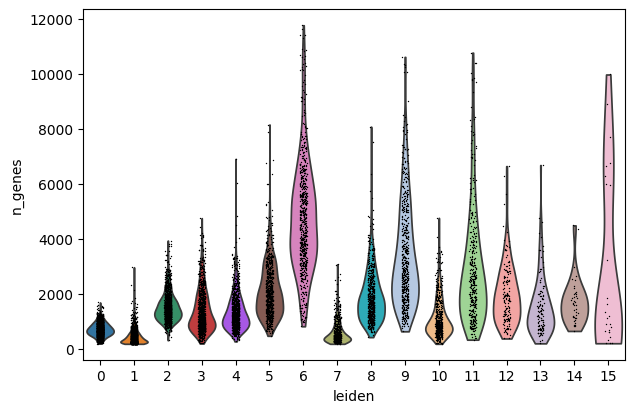

In [48]:
# distribution of ngenes

sc.pl.violin(adata, keys='n_genes', groupby='leiden')

In [51]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: 

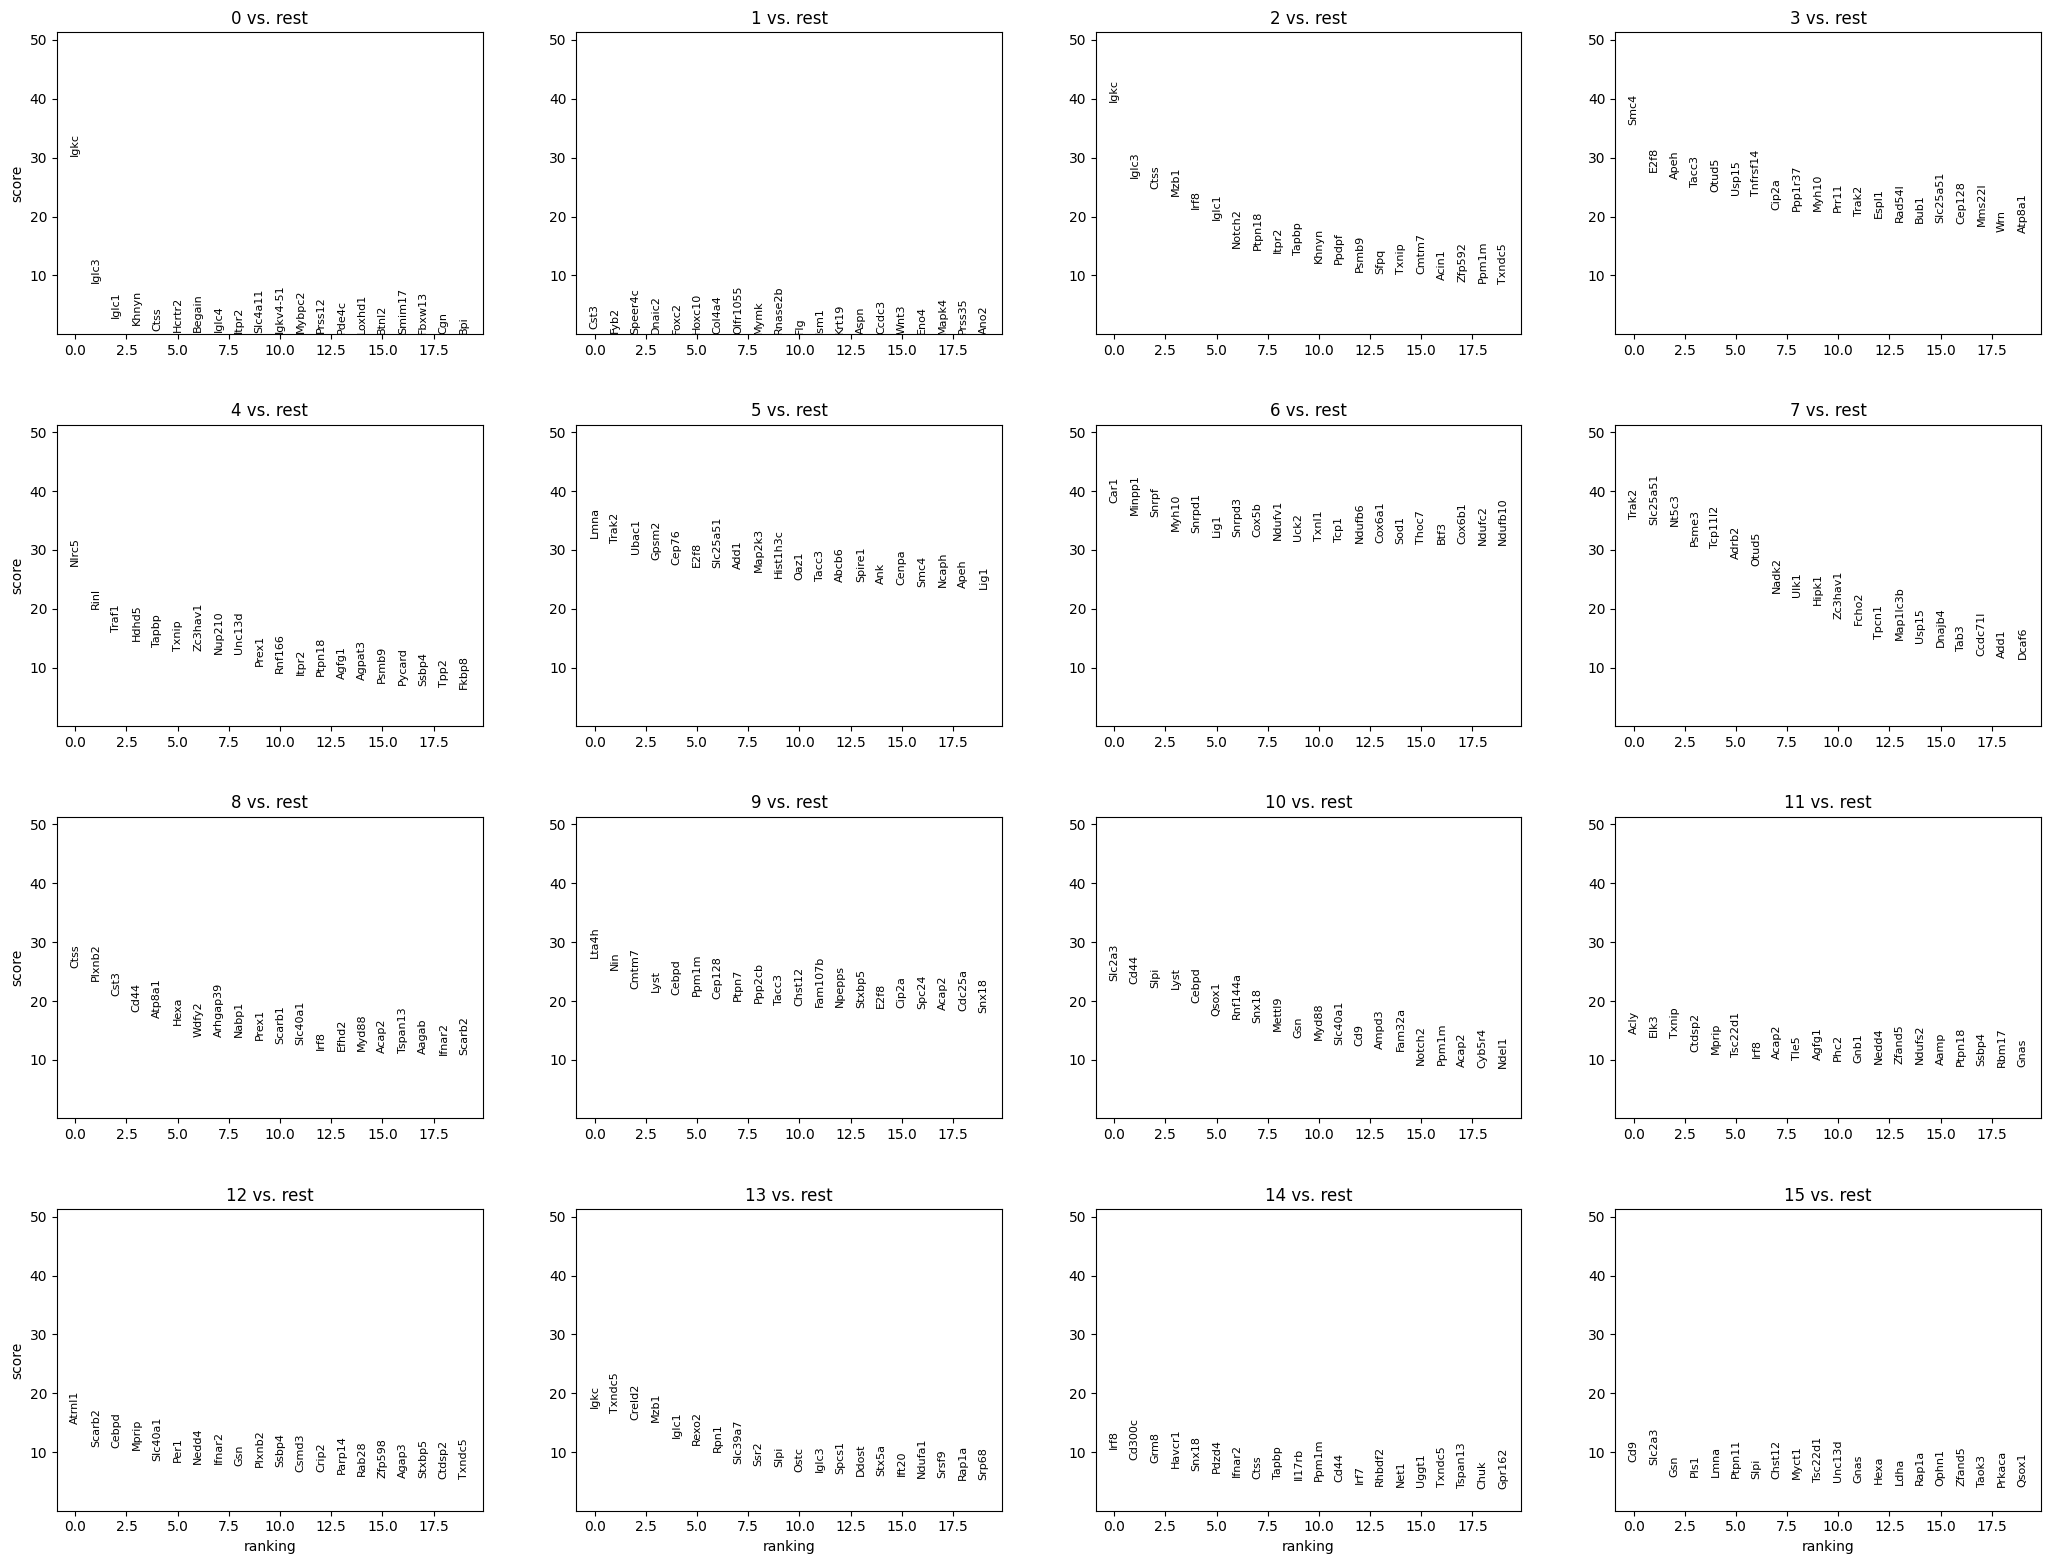

In [52]:
sc.pl.rank_genes_groups(adata, n_genes=20)